# 비정형 데이터 분류

자연어 처리 또는 텍스트 분석을 위한 50,000개의 영화 리뷰가 있는 IMDB 데이터 셋

> https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

## #01. 준비작업

### [1] 패키지 참조

In [73]:
import sys
import os
work_path = os.path.abspath(os.path.join(os.getcwd(), '../../../../'))
sys.path.append(work_path)
from helper.regrassion import *
from helper.plot import *
from helper.util import *
from helper.analysis import *
from helper.classification import *
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.feature_extraction.text import CountVectorizer  
import contractions  # 축약어
import re   # 이메일 주소 제거 re.compile
from bs4 import BeautifulSoup   # html 태그 제거
import nltk 
from nltk.corpus import stopwords   # 불용어
from nltk.stem import PorterStemmer # 단어들 원형으로 표기
from collections import Counter    # 리스트 주면 단어 빈도수           

### [2] 데이터 가져오기

> 데이터 파일이 약 25M 용량이므로 로딩하는데 시간이 오래 소요된다.

| 변수 | 설명 |
|---|---|
| sentiment | 긍정(`positive`), 부정(`negative`) |
| review | 리뷰내용 |

In [91]:
origin = my_read_excel('C:/Users/Jihwan/Desktop/01Class/E.추론통계/E.InferentialStatistics/수업자료/imdb.xlsx')
my_pretty_table(origin.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49998 entries, 0 to 49997
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  49998 non-null  object
 1   review     49998 non-null  object
dtypes: object(2)
memory usage: 781.3+ KB
None

데이터프레임 상위 5개 행
+----+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## #02. 문서 단어 행렬(Document-Term Matrix)의 이해

> 딥러닝에서는 텍스트 토큰화라고 부름.

### [1] 예시 문장

In [92]:
doc1 = "She likes python"
doc2 = "She hates python"

위 문장을 문서 단어 행렬로 표현하면 아래와 같다.

| | She | likes | hates | python |
|---|---|---|---|---|
| doc1 | 1 | 1 | 0 | 1 |
| doc2 | 1 | 0 | 1 | 1 |

즉, 샘플 문장 리스트에서 각 단어가 몇 번씩 등장했는지를 카운트 해서 행렬(=2차 배열)로 표현하는 것.

이렇게 하면 하나의 문장인 `doc1`은 `[1, 1, 0, 1]`이라는 1차원 리스트로 표현되기 때문에 수치적인 연산이 가능해진다.

### [2] 단어 행렬 만들기

In [93]:
count_vec = CountVectorizer()
fit = count_vec.fit_transform([doc1, doc2])
doc_term_matrix = fit.toarray()
doc_term_matrix

array([[0, 1, 1, 1],
       [1, 0, 1, 1]], dtype=int64)

### [3] 단어 행렬 방식의 단점

In [94]:
doc3 = "Peter likes singer"
doc4 = "Singer likes Peter"

| | Potter | likes | Singer |
|---|---|---|---|
| doc1 | 1 | 1 | 1 |
| doc2 | 1 | 1 | 1 |

의미가 다름에도 단어 행렬은 두 문장을 같은 것처럼 표현함.

단어의 순서를 고려하지 않은 분석 방법.

In [95]:
count_vec = CountVectorizer()
fit = count_vec.fit_transform([doc3, doc4])
doc_term_matrix = fit.toarray()
doc_term_matrix

array([[1, 1, 1],
       [1, 1, 1]], dtype=int64)

### [4] 서로 길이가 다른 문장의 경우

In [96]:
doc3 = "Python is very good"
doc4 = "Life is too short, You need Python"

In [97]:
count_vec = CountVectorizer()
fit = count_vec.fit_transform([doc3, doc4])
doc_term_matrix = fit.toarray()
doc_term_matrix

array([[1, 1, 0, 0, 1, 0, 0, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 0, 1]], dtype=int64)

In [98]:
words = count_vec.get_feature_names_out()
words

array(['good', 'is', 'life', 'need', 'python', 'short', 'too', 'very',
       'you'], dtype=object)

In [99]:
DataFrame(doc_term_matrix,columns=words)

,good,is,life,need,python,short,too,very,you
0,1,1,0,0,1,0,0,1,0
1,0,1,1,1,1,1,1,0,1


In [100]:
count_vec.vocabulary_

{'python': 4,
 'is': 1,
 'very': 7,
 'good': 0,
 'life': 2,
 'too': 6,
 'short': 5,
 'you': 8,
 'need': 3}

### [5] 단어 순서 확인하기

#### (1) 기본 단어 행렬 생성

In [101]:
doc1 = "She likes python"
doc2 = "She hates python"

count_vec = CountVectorizer()
fit = count_vec.fit_transform([doc1, doc2])

doc_term_matrix = fit.toarray()
doc_term_matrix

array([[0, 1, 1, 1],
       [1, 0, 1, 1]], dtype=int64)

#### (2) 각 단어별 인덱스 확인

In [102]:
count_vec.vocabulary_

{'she': 3, 'likes': 1, 'python': 2, 'hates': 0}

> hates가 문서 단어의 첫 번째 열에 해당함을 알 수 있다.

#### (3) 인덱스 순서로 단어를 정렬해서 리턴

In [103]:
count_vec.get_feature_names_out()

array(['hates', 'likes', 'python', 'she'], dtype=object)

### [6] 단어 사전 구축

단어 행렬을 생성하기 위해서는 어떤 단어가 몇 번째 인덱스에 올 것인지 정해야 한다.

이를 단어 사전이라 부른다.

기본적으로 머신러닝이 문장을 단어 행렬로 변환(transform)하기 전에 fit 단계에서 이미 단어 사전을 구축한다.

분석가가 분석 목적에 맞는 사전을 미리 정의할 수 있다.

#### (1) 분석가의 사전 정의

사전에 포함되지 않은 단어가 문장에 포함될 경우 무조건 `0`번으로 분류하기 때문에 사전의 첫 번째 단어는 불용어를 의미하는 값으로 정하는 것이 좋다.

In [104]:
my_vocabulary = {'ovv':0, 'java':1, 'html': 2, 'css': 3, 'javascript': 4, 'php': 5, 'sql': 6, 'good': 7}

#### (2) 사전을 품은 변환객체 생성

In [105]:
count_vec = CountVectorizer(
    vocabulary=my_vocabulary,
    stop_words=['is', 'to', 'my'],
    lowercase=True
)

count_vec.vocabulary

{'ovv': 0,
 'java': 1,
 'html': 2,
 'css': 3,
 'javascript': 4,
 'php': 5,
 'sql': 6,
 'good': 7}

In [106]:
fit = count_vec.fit_transform([
    "I can do Java, HTML, CSS, Javascript, PHP, Python",
    "Python is good"
])

doc_term_matrix = fit.toarray()
doc_term_matrix

array([[0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1]], dtype=int64)

> 사전에 포함되지 않은 문장은 버린다.(`0`으로 감별함)

## 03. 영어 축약형 표현의 처리 

In [107]:
contractions.fix("you're happy now")

'you are happy now'

In [108]:
contractions.fix("yall're happy now")

'you all are happy now'

In [109]:
contractions.fix('OMG')

'OH MY GOD'

In [110]:
contractions.add('OMG', 'Oh my god')
contractions.fix("OMG")

'OH MY GOD'

## #04. 데이터 전처리

### [1] 데이터 라벨링

In [111]:
df = my_labelling(origin, 'sentiment')  # 부정이 0이고 긍정이 1
my_pretty_table(df.head())

+----+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### [2] 축약어 처리

In [112]:
df['review'] = df['review'].apply(lambda x: contractions.fix(x))  # apply 반복돌면서 처리해라
my_pretty_table(df.head())

+----+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### [3] 정규표현식 처리

#### (1) 이메일주소 패턴 제거

In [113]:
def remove_emails(x):
    email_pattern = re.compile(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)")
    return re.sub(email_pattern, '', x)

In [114]:
df['review'] = df['review'].apply(lambda x: remove_emails(x))
my_pretty_table(df.head())

+----+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### (2) HTML 태크 패턴 제거

In [115]:
df['review'] = df['review'].apply(lambda x:  BeautifulSoup(x).get_text().strip())  
my_pretty_table(df.head())

+----+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### (3) 그 밖의 몇몇 특수문자 제거

In [116]:
def remove_special_chars(x):
    x = re.sub(r'[^]\w ]+', "", x)
    x = ' '.join(x.split())
    return x

In [117]:
df['review'] = df['review'].apply(lambda x: remove_special_chars(x))
my_pretty_table(df.head())

+----+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### (4) 영어 불용어 처리

##### 불용어 사전 다운로드

In [118]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jihwan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [119]:
sw = stopwords.words('english')
sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

##### 데이터에서 불용어 제거

In [120]:
def remove_stop_words(x):
    global sw
    return ' '.join([word for word in x.split() if word not in sw])


In [121]:
df['review'] = df['review'].apply(lambda x: remove_stop_words(x))
my_pretty_table(df.head())

+----+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### [4] 빈도수가 적은 단어 제거

#### 단어 단위로 분리

In [122]:
df['tidy'] = df['review'].apply(lambda x: x.split())
my_pretty_table(df[['tidy']].head())

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Stemming 

단어들을 '원형'으로 표현하는 것

In [123]:
sample = ['One', 'reviewers', 'mentioned', 'watching']

stemmer = PorterStemmer()

for i in sample:
    print(stemmer.stem(i))

one
review
mention
watch


#### DataFrame 내의 모든 단어를 원형으로 변환

In [124]:
df['tidy'] = df['tidy'].apply(lambda x: [stemmer.stem(i) for i in x])
my_pretty_table(df[['tidy']].head())

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### 모든 데이터를 하나의 리스트로 결합

In [125]:
all_words = []

for word in df['tidy']:
    all_words += word

print("전체 단어 수:", len(all_words))
print(all_words[:100])

전체 단어 수: 6392514
['one', 'review', 'mention', 'watch', '1', 'oz', 'episod', 'hook', 'they', 'right', 'exactli', 'happen', 'meth', 'first', 'thing', 'struck', 'oz', 'brutal', 'unflinch', 'scene', 'violenc', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'heart', 'timid', 'thi', 'show', 'pull', 'punch', 'regard', 'drug', 'sex', 'violenc', 'it', 'hardcor', 'classic', 'use', 'wordit', 'call', 'oz', 'nicknam', 'given', 'oswald', 'maximum', 'secur', 'state', 'penitentari', 'it', 'focus', 'mainli', 'emerald', 'citi', 'experiment', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inward', 'privaci', 'high', 'agenda', 'them', 'citi', 'home', 'manyaryan', 'muslim', 'gangsta', 'latino', 'christian', 'italian', 'irish', 'moreso', 'scuffl', 'death', 'stare', 'dodgi', 'deal', 'shadi', 'agreement', 'never', 'far', 'awayi', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goe', 'show', 'would', 'dare']


In [126]:
count = Counter(all_words)
count_dic = dict(count)
count_dic

{'one': 52578,
 'review': 4186,
 'mention': 2977,
 'watch': 27022,
 '1': 2287,
 'oz': 258,
 'episod': 4827,
 'hook': 577,
 'they': 6273,
 'right': 6657,
 'exactli': 1946,
 'happen': 6920,
 'meth': 104,
 'first': 16819,
 'thing': 16042,
 'struck': 265,
 'brutal': 915,
 'unflinch': 31,
 'scene': 20651,
 'violenc': 1988,
 'set': 7493,
 'word': 3547,
 'go': 18168,
 'trust': 694,
 'show': 19384,
 'faint': 115,
 'heart': 2614,
 'timid': 50,
 'thi': 25744,
 'pull': 1841,
 'punch': 527,
 'regard': 926,
 'drug': 1634,
 'sex': 3228,
 'it': 34481,
 'hardcor': 251,
 'classic': 4132,
 'use': 10031,
 'wordit': 2,
 'call': 5411,
 'nicknam': 83,
 'given': 3497,
 'oswald': 32,
 'maximum': 100,
 'secur': 480,
 'state': 2025,
 'penitentari': 2,
 'focus': 909,
 'mainli': 761,
 'emerald': 14,
 'citi': 2403,
 'experiment': 206,
 'section': 450,
 'prison': 1368,
 'cell': 449,
 'glass': 487,
 'front': 1218,
 'face': 4133,
 'inward': 13,
 'privaci': 25,
 'high': 3835,
 'agenda': 176,
 'them': 82,
 'home': 3661

In [127]:
keys = count_dic.keys()
values = count_dic.values()
count_df = DataFrame({
    "word": keys,
    "count": values
}).sort_values('count')

my_pretty_table(count_df.head())

+--------+-----------------+---------+
|        | word            |   count |
|--------+-----------------+---------|
|  91687 | chowish         |       1 |
| 120970 | 짢town          |       1 |
| 120971 | tamer짢         |       1 |
| 120972 | clit            |       1 |
| 120973 | tollingerrobert |       1 |
+--------+-----------------+---------+


In [128]:
'전체 단어 수:', len(count_df)

('전체 단어 수:', 183376)

In [129]:
pop_word = list(count_df[count_df['count'] > 100]['word'])
len(pop_word)

5520

In [130]:
df['tidy'] = df['tidy'].apply(lambda x: [i for i in x if i in pop_word])
my_pretty_table(df[['tidy']].head())

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### [5] 최종 결과를 하나의 문장으로 병합

In [131]:
df['new_data'] = df['tidy'].apply(lambda x: " ".join(x))
my_pretty_table(df[['new_data']].head())

+----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | new_data                                                                                                              

In [132]:
count_vec = CountVectorizer()
fit = count_vec.fit_transform(df['new_data'])
doc_term_matrix = fit.toarray()
doc_term_matrix[:3]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [133]:
x_train, x_test, y_train, y_test = train_test_split(fit, df['sentiment'], test_size=0.2, random_state=1000)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((39998, 5486), (10000, 5486), (39998,), (10000,))

## #05. 분류 모델 구현

[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
|  7 |   0.1 | l2        |          0.879344 |
|  4 |  0.01 | l2        |          0.877719 |
| 10 |     1 | l2        |          0.864318 |
|  1 | 0.001 | l2        |          0.856518 |
| 13 |    10 | l2        |          0.847242 |
| 16 |   100 | l2        |          0.838242 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.714267 |     0.578371 | 로지스틱회귀의 성능 측정 지표로, 1에 가까울수록 좋은 모델 |
| 정확도(Accuracy)        |     0.927596 |       0.8818 | 예측 결과(TN,FP,TP,TN)가 실제 결과

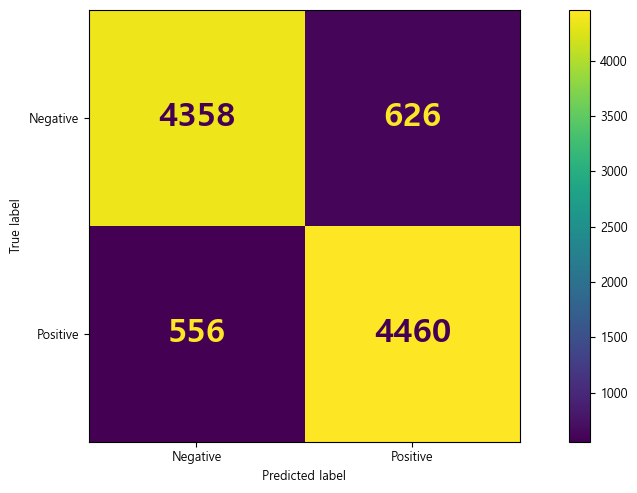


[ROC/PR Curve]


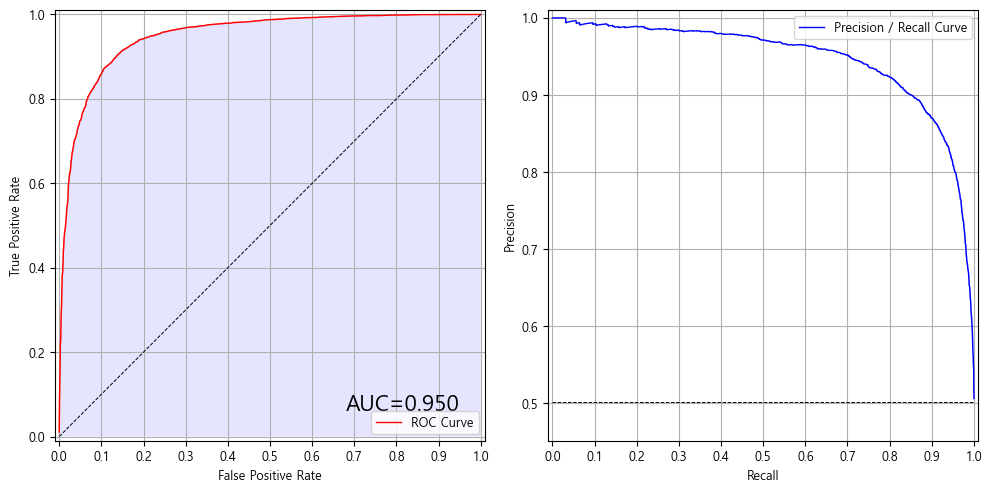


[학습곡선]


TypeError: cannot concatenate object of type '<class 'scipy.sparse._csr.csr_matrix'>'; only Series and DataFrame objs are valid

In [134]:
my_logistic_classification(x_train, y_train, x_test, y_test, report=False)